In [2]:
import subprocess
import os
import ipywidgets as widgets
import pandas as pd
import numpy as np
import folium
from folium import plugins
import branca.colormap as cm
import matplotlib.pyplot as plt
import mplleaflet
from matplotlib.patches import Ellipse

In [3]:
lat = widgets.FloatText(
    value=34.05,
    description='Lat',
)
lon = widgets.FloatText(
    value=-118.2,
    description='Lon',
)
width = widgets.FloatText(
    value=2,
    description='Width',
)
height = widgets.FloatText(
    value=2,
    description='Height')
t1 = widgets.DatePicker(description='Time 1')
t2 = widgets.DatePicker(description='Time 2')
file_name = widgets.Text(description='Output name', value='displacement')
all_widgets = [lat, lon, width, height, t1, t2, file_name]
widgets.GridBox(all_widgets, layout=widgets.Layout(
    grid_template_columns='repeat(2,400px)'))

GridBox(children=(FloatText(value=34.05, description='Lat'), FloatText(value=-118.2, description='Lon'), Float…

In [4]:
disp_args = f'python getDisplacement.py --lat {lat.value} --lon {lon.value} --width {width.value} --height {height.value} -t1 {t1.value.strftime("%Y-%m-%d")} -t2 {t2.value.strftime("%Y-%m-%d")} -o {file_name.value}'

In [5]:
process = subprocess.getoutput(disp_args)

In [6]:
def load_gps_data(filename):
    '''
    

    Parameters
    ----------
    filename : 
        GPS data as retreived from getDisplacement.py
    -------
    Pandas Dataframe of Lon, Lat, and Delta Values

    '''
    gps_in = np.loadtxt(filename, skiprows=(1), usecols=(1,2,3,4,5,6,7,8))
    gps_dict = {'Lon': gps_in[:,0], 'Lat': gps_in[:,1], 'Delta E': gps_in[:,2],
                'Delta N': gps_in[:,3], 'Delta V': gps_in[:,4], 'Sigma E': gps_in[:,5], 'Sigma N':gps_in[:,6], 'Sigma V': gps_in[:,7]}
    gps_df = pd.DataFrame(gps_dict)
    sites= np.loadtxt(filename, skiprows=(1), usecols=(0),dtype=str)
    gps_df['Site'] = sites
    
    return gps_df

In [7]:
gps_disp = load_gps_data(f'{file_name.value}_table.txt')

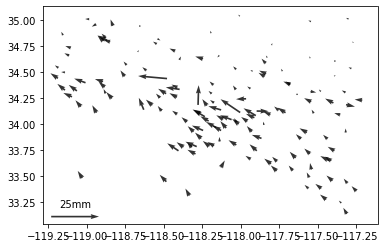

In [8]:
fig, ax = plt.subplots()
q = ax.quiver(gps_disp['Lon'], gps_disp['Lat'],gps_disp['Delta E'],gps_disp['Delta N'], 
              color='black', alpha=0.8,scale=175)


ax.quiverkey(q, .2, .15, 25, '25mm',labelpos='N', coordinates='figure') # adds scale quiver with label 
ax.plot() 
geoj=mplleaflet.fig_to_geojson(fig=fig) # quiver key not saved in geojson, don't know how to get key into map. 
fig


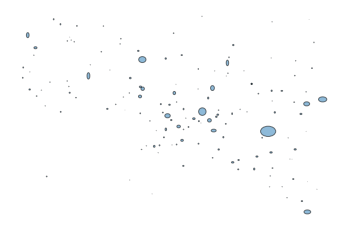

In [12]:
#normalize sigmas
def normalize_col(col):
    max_val = col.max()
    min_val = col.min()
    result = (col - min_val)/(max_val-min_val)
    return result
normal_sigmaE = normalize_col(gps_disp['Sigma E'])
normal_sigmaN = normalize_col(gps_disp['Sigma N'])
e = []
fig2 = plt.figure(0)
ax2 = fig2.add_subplot(111)
for x,y , w, h in zip(gps_disp['Lon'], gps_disp['Lat'], normal_sigmaE, normal_sigmaN):
    ellipse = Ellipse(xy=(x, y), width=w/10, height=h/10,
                      edgecolor='black', alpha=.5,)
    ax2.add_patch(ellipse)

ax2.plot()
fig2.frameon  = False
fig2.gca().xaxis.set_major_locator(plt.NullLocator())
fig2.gca().yaxis.set_major_locator(plt.NullLocator())
ax2.set_axis_off()
plt.close(fig2)
fig2.savefig(f'error_elippse.png', bbox_inches='tight', 
                pad_inches=0,dpi=600 )
fig2
# I cannot figure out how to get this onto the map. Displaying it as a static image distorts the placement
# due to geographic distortions on the map itself. 

In [10]:
def create_map(df, lon_col='Lon', lat_col='Lat', data_col='Delta V', site_col='Site'):
    '''
    Parameters
    ----------
    df :
        Pandas dataframe with column of lat, long, and a data column
    lon_col:
        Name of column with longitude coords. Default value of 'Lon'
    lat_col:
        Name of column with lattitude coords. Default value of 'Lat'
    data_col:
        Name of column with values to be colormapped. Default is 'Delta N'
    site_col:
        Name of column with GPS site names. 
    -------
    Returns:
        Folium map object
    '''

    start_cords = (df[lat_col].median(),
                   df[lon_col].median())
    my_map = folium.Map(start_cords,
                        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}',
                        attr='Tiles &copy; Esri',zoom_start=8, width=750, height=465,contol_scale=True)
    plugins.Fullscreen(position='topleft').add_to(my_map)

    # making MPL seismic colormap in Branca
    colors_list = ['blue', 'white', 'red']
    minimum = df[data_col].min()
    maximum = df[data_col].max()
    colormap = cm.LinearColormap(
        colors=colors_list, vmin=minimum, vmax=maximum)
    stations = folium.FeatureGroup(
        name=f'Displacement for {df[data_col].name}')
    for cord, disp, site in zip(zip(df[lat_col], df[lon_col]), df[data_col], df[site_col]):
        folium.Circle(
            location=cord,
            radius=abs(disp)*250,
            fill=True,
            color=colormap(disp),
            popup=f'Vertical Displacement:{disp}    Site:{site}',
            stroke=True,
            weight=1,
            fill_opacity=.8
        ).add_to(stations)
    feature_group0 = folium.FeatureGroup(name='Vector field')
    for feature in geoj['features']:
        if feature['geometry']['type'] == 'Point':
            lon, lat = feature['geometry']['coordinates']
            div = feature['properties']['html']

            icon_anchor = (feature['properties']['anchor_x'],
                           feature['properties']['anchor_y'])

            icon = folium.features.DivIcon(html=div,
                                           icon_anchor=icon_anchor)
            marker = folium.Marker([lat, lon], icon=icon)
            feature_group0.add_child(marker)
        else:
            msg = "Unexpected geometry {}".format
            raise ValueError(msg(feature['geometry']))
    my_map.add_child(feature_group0)
    my_map.add_child(stations)
    my_map.add_child(colormap)
#     folium.raster_layers.ImageOverlay('error_elippse.png', [[df[lat_col].min(
#     ), df[lon_col].min()], [df[lat_col].max(), df[lon_col].max()]], name='Error Ellipse').add_to(my_map)
    my_map.add_child(folium.LayerControl(postion='bottomleft'))
    
    return my_map

In [11]:
# I have no idea why the arrows are plotting off center from the circles. Seems super inconsistent. 
create_map(gps_disp)